# Importing Libraries <a name='libraries'></a>

In [55]:
import pandas as pd
import numpy as np
# from isodate import parse_duration
import matplotlib.pyplot as plt
from googleapiclient.discovery import build
import nltk
nltk.download('stopwords')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\umesh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\umesh\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\umesh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Youtube Data Fetching

In [21]:
# Utils.py

In [22]:
import pandas as pd
class Utils:

    # Function to get video details
    def get_video_details(youtube, video_id):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=video_id
        )
        response = request.execute()

        if not response['items']:
            return None

        video_info = response['items'][0]
        snippet = video_info['snippet']
        statistics = video_info['statistics']
        content_details = video_info['contentDetails']
        title = snippet.get('title', "")  # Extract title
        description = snippet.get('description', "")
        view_count = statistics.get('viewCount', 0)
        like_count = statistics.get('likeCount', 0)
        dislike_count = statistics.get('dislikeCount', 0)
        comment_count = statistics.get('commentCount', 0)
        duration = content_details.get('duration', "")
        favorite_count = statistics.get('favoriteCount', 0)

        return {
            "video_id": video_id,
            "title": title,
            "description": description,
            "view_count": view_count,
            "like_count": like_count,
            "dislike_count": dislike_count,
            "comment_count": comment_count,
            "duration": duration,
            "favorite_count": favorite_count
        }

    # Function to get comments
    def get_comments(youtube, video_id):
        request = youtube.commentThreads().list(
            part="snippet",
            videoId=video_id,
            maxResults=100,
            order="relevance"  # Order comments by relevance (most popular)
        )
        response = request.execute()

        comments = []
        for item in response.get('items', []):
            comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
            comments.append(comment)

        return comments

    # Function to save results to a CSV file
    def save_results_to_csv(results, start_video_id, end_video_id):
        if results:
            output_filename = f'./files/output_files/youtube_video_data_{start_video_id}_to_{end_video_id}.csv'
            results_df = pd.DataFrame(results)
            results_df.to_csv(output_filename, index=False)
            print(f"Saved results to {output_filename}")

In [23]:
# Data_extractor.py

In [24]:
import pandas as pd
import googleapiclient.discovery
from googleapiclient.discovery import build
from Utils import Utils as utils
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()

# Create YouTube resource object
youtube = build('youtube',
                'v3',
                developerKey=os.getenv("API_KEY"))

# Load the CSV file with status
file_path = './files'
csv_file_path = file_path + '/youtube_video_links.csv'
df = pd.read_csv(csv_file_path)

print("File Size ", df.size)

# Check if 'status' column exists
if 'status' not in df.columns:
    # Add a status column and initialize with 'Not Fetched'
    df['status'] = 'Not Fetched'

    # Save the updated CSV file
    df.to_csv(csv_file_path, index=False)

# Initialize or get the start index
start_index = 0
# if 'd1' in df.columns and pd.notna(df.at[0, 'd1']) and df.at[0, 'd1'] != 0:
#     start_index = int(df.at[0, 'd1'])

print(f"Starting from index {start_index}")

# Initialize start row number
start_row_number = start_index  # Initialize start_row_number here

# List to store results
results = []

# Get the start video ID for the output filename
start_video_id = None
comments = None

# Process each video ID from the start index
for idx in range(start_index, len(df)):
    print(f"Processing video {idx}")
    is_comment_disabled = False
    # reset comment for each iteration
    comments = ''

    row = df.iloc[idx]
    if row['status'] == 'Not Fetched':
        if start_video_id is None:
            start_video_id = row['youtubeId']

        video_id = row['youtubeId']
        try:
            video_details = utils.get_video_details(youtube, video_id)
            comments = utils.get_comments(youtube, video_id)
        except googleapiclient.errors.HttpError as e:
            # print(e)
            if e.resp.status == 404:
                print(f"Video not found: {video_id}")
                df.at[idx, 'status'] = 'Video Not Found'
                continue
            elif e.resp.status == 403:
                error_reason = e.content.decode().lower()
                if "exceeded" in error_reason:
                    print(f"Quota exceeded. Stopping the execution.")
                    break  # Stop the execution if quota is exceeded
                elif "commentsdisabled" in error_reason:
                    print(f"Error fetching data for video {video_id}: commentsdisabled")
                    is_comment_disabled = True
                    # continue
            elif e.resp.status in [500, 503]:
                print(f"Temporary server error for video {video_id}")
                break
            else:
                print(f"Error fetching data for video {video_id}")
                continue

        if video_details:
            video_details['comments'] = comments
            results.append(video_details)
            df.at[idx, 'status'] = 'Fetched, Comment Disabled' if is_comment_disabled else 'Fetched'

        # Periodically save results and update CSV
        if len(results) >= 5000:  # Save every 1000 records
            end_video_id = video_details['video_id']
            utils.save_results_to_csv(results, start_row_number, idx)
            results = []  # Clear results after saving
            start_video_id = None  # Reset start_video_id for the next batch
            start_row_number = idx + 1  # Update start row number

            # Update the d1 column with the current index
            df.at[0, 'd1'] = idx
            df.to_csv(csv_file_path, index=False)

# print("results ", results)
# Save any remaining results
if results:
    end_video_id = results[-1]['video_id']
    utils.save_results_to_csv(results, start_row_number, idx)
    # Update the d1 column with the current index
    df.at[0, 'd1'] = idx
    df.to_csv(csv_file_path, index=False)
print(df.head())

print("Processing complete.")


# Analysis of Video links

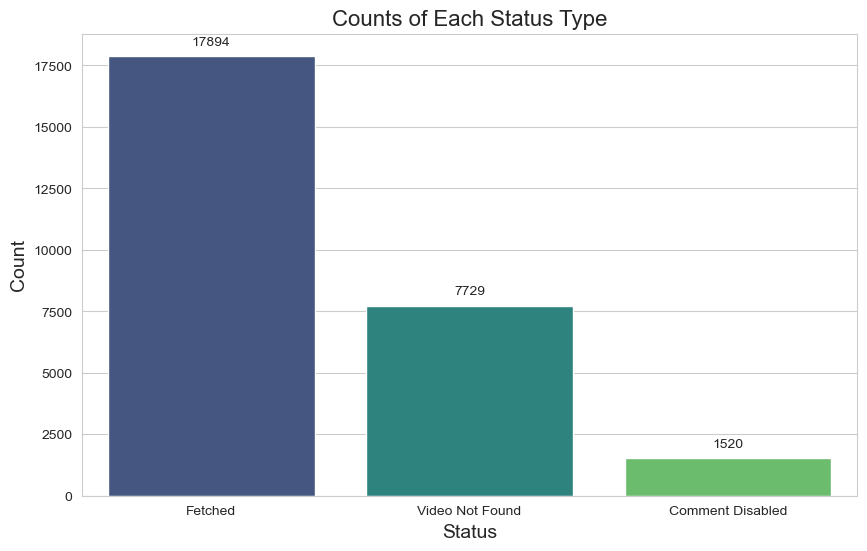

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset from the CSV file
df = pd.read_csv('files/youtube_video_links.csv')

# Count the occurrences of each status type
fetched_count = df['status'].str.contains('Fetched').sum()
video_not_found_count = df['status'].str.contains('Video Not Found').sum()
comment_disabled_count = df['status'].str.contains('Comment Disabled').sum()

# Create a DataFrame for visualization
status_counts = pd.DataFrame({
    'Status': ['Fetched', 'Video Not Found', 'Comment Disabled'],
    'Count': [fetched_count, video_not_found_count, comment_disabled_count]
})

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x='Status', y='Count', data=status_counts, palette='viridis')

# Add labels to the plot
bar_plot.set_xlabel('Status', fontsize=14)
bar_plot.set_ylabel('Count', fontsize=14)
bar_plot.set_title('Counts of Each Status Type', fontsize=16)

# Annotate the bars with the counts
for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.0f'),
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha = 'center', va = 'center',
                      xytext = (0, 10),
                      textcoords = 'offset points')

# Show the plot
plt.show()


# Data Pre-processing <a name='pre_process'></a>

In [57]:
df=pd.read_csv('files/output_files/final_data.csv')

In [58]:
df.head()

,video_id,title,description,view_count,like_count,dislike_count,comment_count,duration,favorite_count,comments
0,K26_sDKnvMU,Toy Story (1995) Trailer 2 (VHS Capture),Trailer for Toy Story (1995) captured from the...,116721,150,0,0,PT1M31S,0,NaN
1,3LPANjHlPxo,Jumanji Trailer 1995,Jumanji Trailer 1995\nDirector: Joe Johnston\n...,196804,286,0,0,PT2M48S,0,NaN
2,rEnOoWs3FuA,Grumpier Old Men - Trailer,"The more things change, the more they stay the...",221645,220,0,13,PT1M52S,0,"['I&#39;m watching this now, it never gets old..."
3,j9xml1CxgXI,Waiting To Exhale,Whitney Houston and Angela Bassett star in thi...,433535,0,0,0,PT2M40S,0,NaN
4,2GfZl4kuVNI,Heat Trailer HD (1995),"Director: Michael Mann.\nCast: Al Pacino, Robe...",1460783,7940,0,672,PT2M28S,0,['Hollywood will never be the same once Al and...


In [59]:
df.drop('dislike_count', axis=1, inplace=True)

In [29]:
# df.drop('video_id', axis=1, inplace=True)

In [60]:
# Get unique values of the 'favorite_count' column
unique_favorite_counts = df['favorite_count'].unique()

# Print the unique values
print(unique_favorite_counts)

[0]


In [31]:
# All favorite count column has 0 , so we are dropping the column alltogether.

In [61]:
df.drop('video_id', axis=1, inplace=True)

In [62]:
df.isna().sum()

title                0
description        440
view_count           0
like_count           0
comment_count        0
duration             0
favorite_count       0
comments          1487
dtype: int64

In [63]:
df['duration'] = pd.to_timedelta(df['duration'])

In [64]:
#Converting float data types to int
placeholder_value = -1  # Choose an appropriate placeholder value
df['comment_count'].fillna(placeholder_value, inplace=True)
df['like_count'].fillna(placeholder_value, inplace=True)
df['view_count'].fillna(placeholder_value, inplace=True)

df['comment_count']=df['comment_count'].round().astype(int)
df['like_count']=df['like_count'].round().astype(int)

C:\Users\umesh\AppData\Local\Temp\ipykernel_12468\140956340.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['comment_count'].fillna(placeholder_value, inplace=True)
C:\Users\umesh\AppData\Local\Temp\ipykernel_12468\140956340.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

In [65]:
df.head()

,title,description,view_count,like_count,comment_count,duration,favorite_count,comments
0,Toy Story (1995) Trailer 2 (VHS Capture),Trailer for Toy Story (1995) captured from the...,116721,150,0,0 days 00:01:31,0,NaN
1,Jumanji Trailer 1995,Jumanji Trailer 1995\nDirector: Joe Johnston\n...,196804,286,0,0 days 00:02:48,0,NaN
2,Grumpier Old Men - Trailer,"The more things change, the more they stay the...",221645,220,13,0 days 00:01:52,0,"['I&#39;m watching this now, it never gets old..."
3,Waiting To Exhale,Whitney Houston and Angela Bassett star in thi...,433535,0,0,0 days 00:02:40,0,NaN
4,Heat Trailer HD (1995),"Director: Michael Mann.\nCast: Al Pacino, Robe...",1460783,7940,672,0 days 00:02:28,0,['Hollywood will never be the same once Al and...


In [66]:
df['comments']=df['comments'].fillna("")
df['description']=df['description'].fillna("")

In [67]:
df.isna().sum()

title             0
description       0
view_count        0
like_count        0
comment_count     0
duration          0
favorite_count    0
comments          0
dtype: int64

In [68]:
df.shape

(17373, 8)

In [69]:
df.columns

Index(['title', 'description', 'view_count', 'like_count', 'comment_count',
       'duration', 'favorite_count', 'comments'],
      dtype='object')

## List of the top-10 videos based on total views: <a name='top_10Videos'></a>

In [71]:
# top_10_videos = df.nlargest(10, 'viewcount')['title']

df['view_count'] = pd.to_numeric(df['view_count'], errors='coerce')
df_sorted = df.sort_values(by='view_count',ascending=False)


top_10_videos = df_sorted.head(10)



In [72]:
print(top_10_videos[['title', 'view_count']])

                                                   title  view_count
15460           John Legend - All of Me (Official Video)  2380229481
16842     Fresh Guacamole by PES | Oscar Nominated Short   477180780
17272                            Beastie Boys - Sabotage   130409198
3930   Unfaithful (2002) - The Other Woman Scene (1/3...   126789092
14295     Britney Spears - Ooh La La (From The Smurfs 2)   124544264
16019                     ILO ILO 爸媽不在家 Official Trailer    91518976
10500                                     Growth Trailer    71939300
11880  Transformers 3 Dark of the Moon Teaser Trailer...    53112347
15573  The Fault In Our Stars | Official Trailer [HD]...    48514540
17215                                              Kiwi!    47885982


## List of the bottom-10 videos based on total views: <a name='bottom_10Videos'></a>

In [74]:
df_sorted = df[df.view_count > 0].sort_values(by='view_count')
bottom_10_videos = df_sorted.head(10)

In [75]:
print(bottom_10_videos[['title', 'view_count']])

                                                   title  view_count
14053                        Introduction - Hilton, 2013          17
14880          Cornerstone Festival Wooden Bridge (2012)          46
16324                                       Freedom 2009          46
15337                         me with warheads two(2008)          52
16757                             Flesh and Blood (1922)          97
14999                      American Scary (2006) Trailer         107
14266                                          rafa 2012         108
15098                 Paranoia Agent (2004) Anime Review         113
13387  97 Percent True — "Joyous Intoxication of Buil...         138
15090           May I? (From 'We're Not Dressing', 1934)         156


C:\Users\umesh\AppData\Local\Temp\ipykernel_12468\1085479257.py:21: UserWarning: Glyph 29240 (\N{CJK UNIFIED IDEOGRAPH-7238}) missing from current font.
  plt.tight_layout()
C:\Users\umesh\AppData\Local\Temp\ipykernel_12468\1085479257.py:21: UserWarning: Glyph 23229 (\N{CJK UNIFIED IDEOGRAPH-5ABD}) missing from current font.
  plt.tight_layout()
C:\Users\umesh\AppData\Local\Temp\ipykernel_12468\1085479257.py:21: UserWarning: Glyph 19981 (\N{CJK UNIFIED IDEOGRAPH-4E0D}) missing from current font.
  plt.tight_layout()
C:\Users\umesh\AppData\Local\Temp\ipykernel_12468\1085479257.py:21: UserWarning: Glyph 22312 (\N{CJK UNIFIED IDEOGRAPH-5728}) missing from current font.
  plt.tight_layout()
C:\Users\umesh\AppData\Local\Temp\ipykernel_12468\1085479257.py:21: UserWarning: Glyph 23478 (\N{CJK UNIFIED IDEOGRAPH-5BB6}) missing from current font.
  plt.tight_layout()
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29240 (\N{CJK UNIFIED IDEOGRAPH-7238

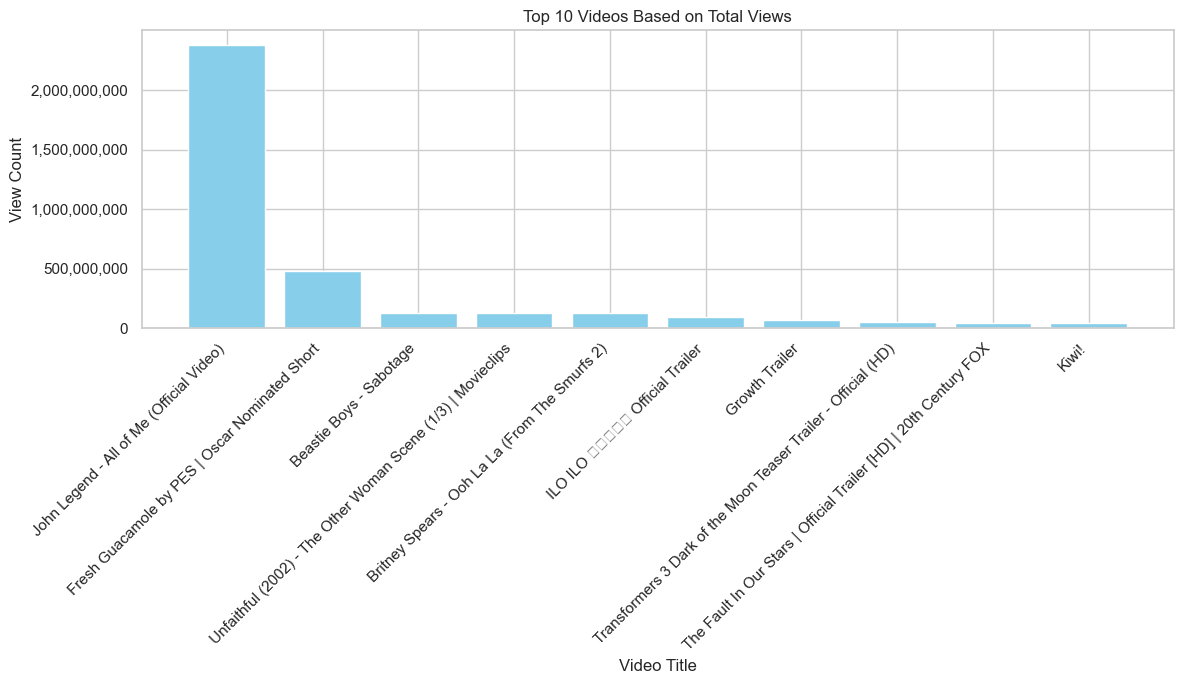

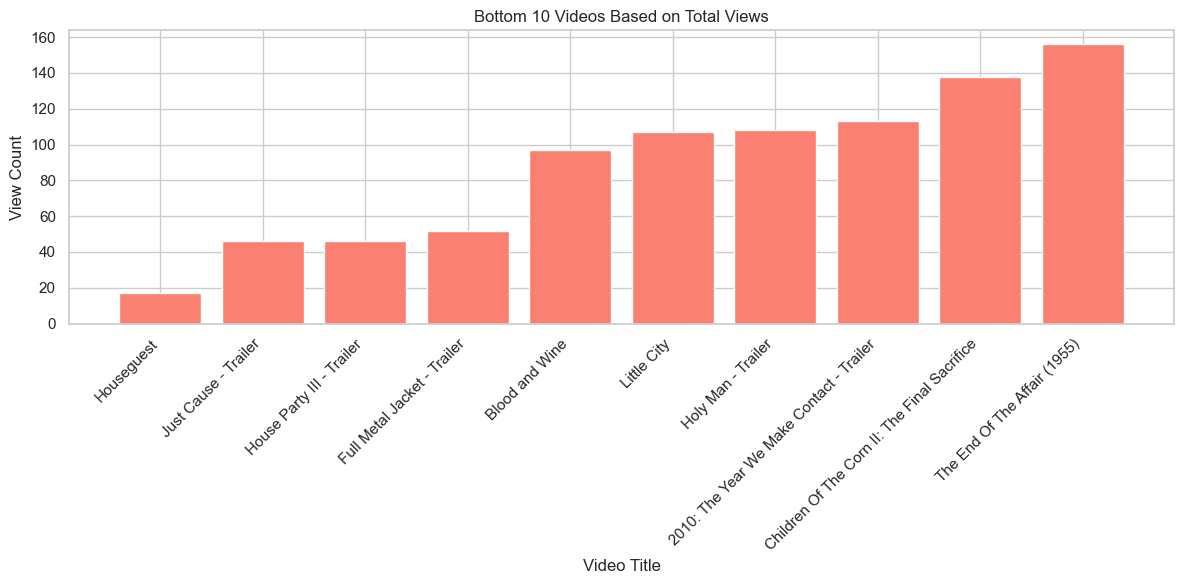

In [92]:
# Sort the DataFrame by view counts in descending order for top 10 videos
df_top = df.nlargest(10, 'view_count')

# Sort the DataFrame by view counts in ascending order for bottom 10 videos
df_bottom = df.nsmallest(10, 'view_count')

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Create a bar chart for the top 10 videos
plt.figure(figsize=(12, 7))
plt.bar(df_top['title'], top_10_videos['view_count'], color='skyblue')
plt.xlabel('Video Title')
plt.ylabel('View Count')
plt.title('Top 10 Videos Based on Total Views')

# Format the y-axis to display numbers in regular notation
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Create a bar chart for the bottom 10 videos
plt.figure(figsize=(12, 6))
plt.bar(df_bottom['title'],bottom_10_videos ['view_count'], color='salmon')
plt.xlabel('Video Title')
plt.ylabel('View Count')
plt.title('Bottom 10 Videos Based on Total Views')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## The most liked video:<a name='most_liked_video'></a>

In [77]:
df['like_count'] = pd.to_numeric(df['like_count'], errors='coerce')

df_sorted_likes = df.sort_values(by='like_count', ascending=False)

most_liked_video = df_sorted_likes.head(1)


In [78]:
print(most_liked_video[['title', 'like_count']])

                                          title  like_count
15460  John Legend - All of Me (Official Video)    13159731


## The least liked video:<a name='least_liked_video'></a>

In [79]:
# # Filter out rows with zero 'Like Count'
# non_zero_likes = df[df['Like Count'] > 0]

df_sorted_likes = df[df.like_count > 0].sort_values(by='like_count')
least_liked_video = df_sorted_likes.head(5)


In [80]:
print(least_liked_video[['title', 'like_count']])

                                 title  like_count
11635               Hans & Ingrid 2009           1
16886   Lili's Apron 1  gregory dayton           1
10818      Perestroika 2009 Trailer HD           1
15806           So Much So Fast (2006)           1
12575  The Scenesters (2009) - trailer           1


## The Video with Highest Duration:<a name='highest_duration_video'></a>

In [81]:
# video_with_highest_duration = df[df['Duration'] == df['Duration'].max()]
# video_with_highest_duration['title']

# Convert the duration to a timedelta format
df['duration'] = pd.to_timedelta(df['duration'])

df_sorted_duration = df.sort_values(by='duration', ascending=False)
video_highest_duration = df_sorted_duration.head(1)

print(video_highest_duration[['title', 'duration']])

                            title        duration
17113  Escape Me Never (1935) 1/9 3 days 02:40:22


## Sentiment Analysis:<a name='sentiment_analysis'></a>

In [82]:
!pip install vaderSentiment

Defaulting to user installation because normal site-packages is not writeable


In [83]:
def preprocess_text(text):
    """
    Preprocesses the text by converting to lowercase, tokenizing, and removing stopwords.

    Args:
        text (str): The input text to be preprocessed.

    Returns:
        str: The preprocessed text.
    """
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    tokens = [token for token in tokens if token.isalnum()]
    tokens = [token for token in tokens if token not in nltk.corpus.stopwords.words('english')]

    processed_text = ' '.join(tokens)
    return processed_text

In [84]:
df1 = df.head()

In [85]:
def analyze_sentiment(text):
    """
    Analyzes the sentiment of the given text using VADER (Valence Aware Dictionary and sEntiment Reasoner).

    Args:
        text (str): The text for which sentiment analysis is to be performed.

    Returns:
        tuple: A tuple containing the sentiment label and the sentiment score.
    """
    analyzer = SentimentIntensityAnalyzer()
    if text == "":
        return "NO", 0
    preprocessed_text = preprocess_text(text)
    sentiment_scores = analyzer.polarity_scores(preprocessed_text)
    compound_score = sentiment_scores['compound']
    if compound_score >= 0.05:
        return "Positive", compound_score
    elif compound_score <= -0.05:
        return "Negative", compound_score
    else:
        return "Neutral", compound_score

# Initialize lists for storing sentiment scores and labels
sentiment_score = []
scores = []

# Iterate through the comments and perform sentiment analysis
for count, comment in enumerate(df['comments']):
    sentiment, score = analyze_sentiment(comment)
    sentiment_score.append(sentiment)
    scores.append(score)

# Add the sentiment analysis results to the DataFrame
df['Sentiment'] = sentiment_score
df['Scores'] = scores


In [86]:
# Save the updated DataFrame to a CSV file
df.to_csv('youtube_data_with_sentiment.csv', index=False)

In [87]:
df.head()

,title,description,view_count,like_count,comment_count,duration,favorite_count,comments,Sentiment,Scores
0,Toy Story (1995) Trailer 2 (VHS Capture),Trailer for Toy Story (1995) captured from the...,116721,150,0,0 days 00:01:31,0,,NO,0.0000
1,Jumanji Trailer 1995,Jumanji Trailer 1995\nDirector: Joe Johnston\n...,196804,286,0,0 days 00:02:48,0,,NO,0.0000
2,Grumpier Old Men - Trailer,"The more things change, the more they stay the...",221645,220,13,0 days 00:01:52,0,"['I&#39;m watching this now, it never gets old...",Positive,0.7506
3,Waiting To Exhale,Whitney Houston and Angela Bassett star in thi...,433535,0,0,0 days 00:02:40,0,,NO,0.0000
4,Heat Trailer HD (1995),"Director: Michael Mann.\nCast: Al Pacino, Robe...",1460783,7940,672,0 days 00:02:28,0,['Hollywood will never be the same once Al and...,Positive,0.9999


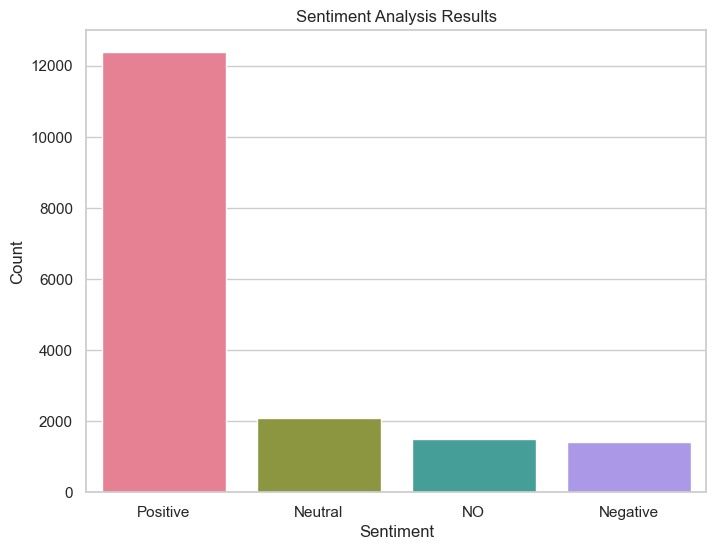

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a bar chart using Seaborn
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")
sns.countplot(x='Sentiment', data=df, palette=sns.color_palette("husl", df['Sentiment'].nunique()), order=df['Sentiment'].value_counts().index)
plt.title('Sentiment Analysis Results')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

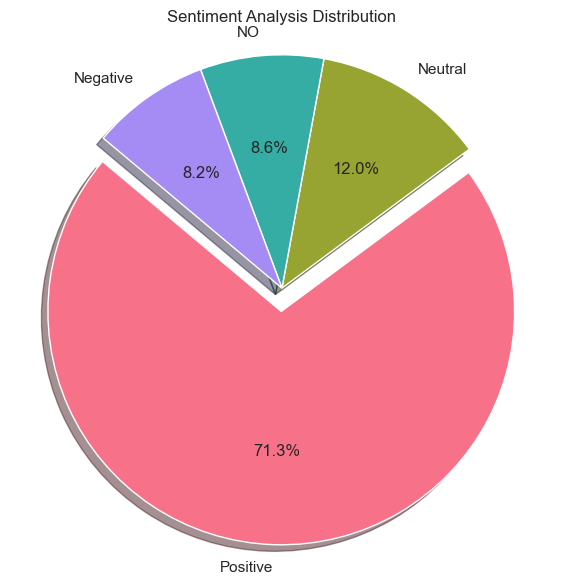

In [89]:
# Create a pie chart using Matplotlib
labels = df['Sentiment'].value_counts().index
sizes = df['Sentiment'].value_counts().values
colors = sns.color_palette("husl", len(labels))  # Generate a color palette based on the number of unique sentiments
explode = [0.1 if i == 0 else 0 for i in range(len(labels))]  # explode the 1st slice

plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140, explode=explode)
plt.axis('equal')
plt.title('Sentiment Analysis Distribution')
plt.show()

In [90]:
df[df['Sentiment']=="Negative"]

,title,description,view_count,like_count,comment_count,duration,favorite_count,comments,Sentiment,Scores
9,Dracula: Dead and Loving It - Trailer,A comic reinvention of the Bela Lugosi classic...,149950,0,10,0 days 00:02:00,0,"['Aaliyah loved this one', 'The last line in t...",Negative,-0.8934
38,Guardian Angel (1994) trailer,production of the PM Entertainment,14945,59,4,0 days 00:01:51,0,"['Keep an eye out for you Stingray! Hey, it&#3...",Negative,-0.1531
39,Lamerica - Trailer,"L'odissea di alcuni italiani in Albania, alla ...",7178,10,2,0 days 00:02:41,0,['trailer and teaser trailer ;)'],Negative,-0.2500
45,Eye for an Eye (1996) Trailer,"An excellent movie! Kiefer is really creepy, b...",249460,238,104,0 days 00:00:55,0,"['The whole cast was amazing in this movie, bu...",Negative,-0.9974
46,"Richard Dreyfuss in ""Mr Hollands Opus"" 1996 Mo...",When we're young our dreams lie out in front o...,18258,31,1,0 days 00:01:04,0,"['i,ll never understand why richard dreyfuss n...",Negative,-0.4449
...,...,...,...,...,...,...,...,...,...,...
17340,The Distance Trailer,"Directed by Sergio Caballero\n\n""A heist-movie...",11527,21,4,0 days 00:01:01,0,['What the hell is this'],Negative,-0.6808
17350,Janji Joni (Joni's Promise) (2005) Trailer,I couldn't find a hi-res file. Hopefully I can...,47464,364,25,0 days 00:01:01,0,['Inget banget nonton film ini tahun 2005 dape...,Negative,-0.3818
17351,THE MAN WHO COULD CHEAT DEATH - 1959,Hammer Horror classic. Dr. Bonner plans to liv...,34837,97,7,0 days 00:02:12,0,['This scared the life out of me when I first ...,Negative,-0.8683
17359,Carts of Darkness,"In North Vancouver, Canada, a group of homeles...",38583,496,1,0 days 00:59:30,0,['Definitely offers a new perspective. Those g...,Negative,-0.1531


C:\Users\umesh\AppData\Local\Temp\ipykernel_12468\3652576196.py:25: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


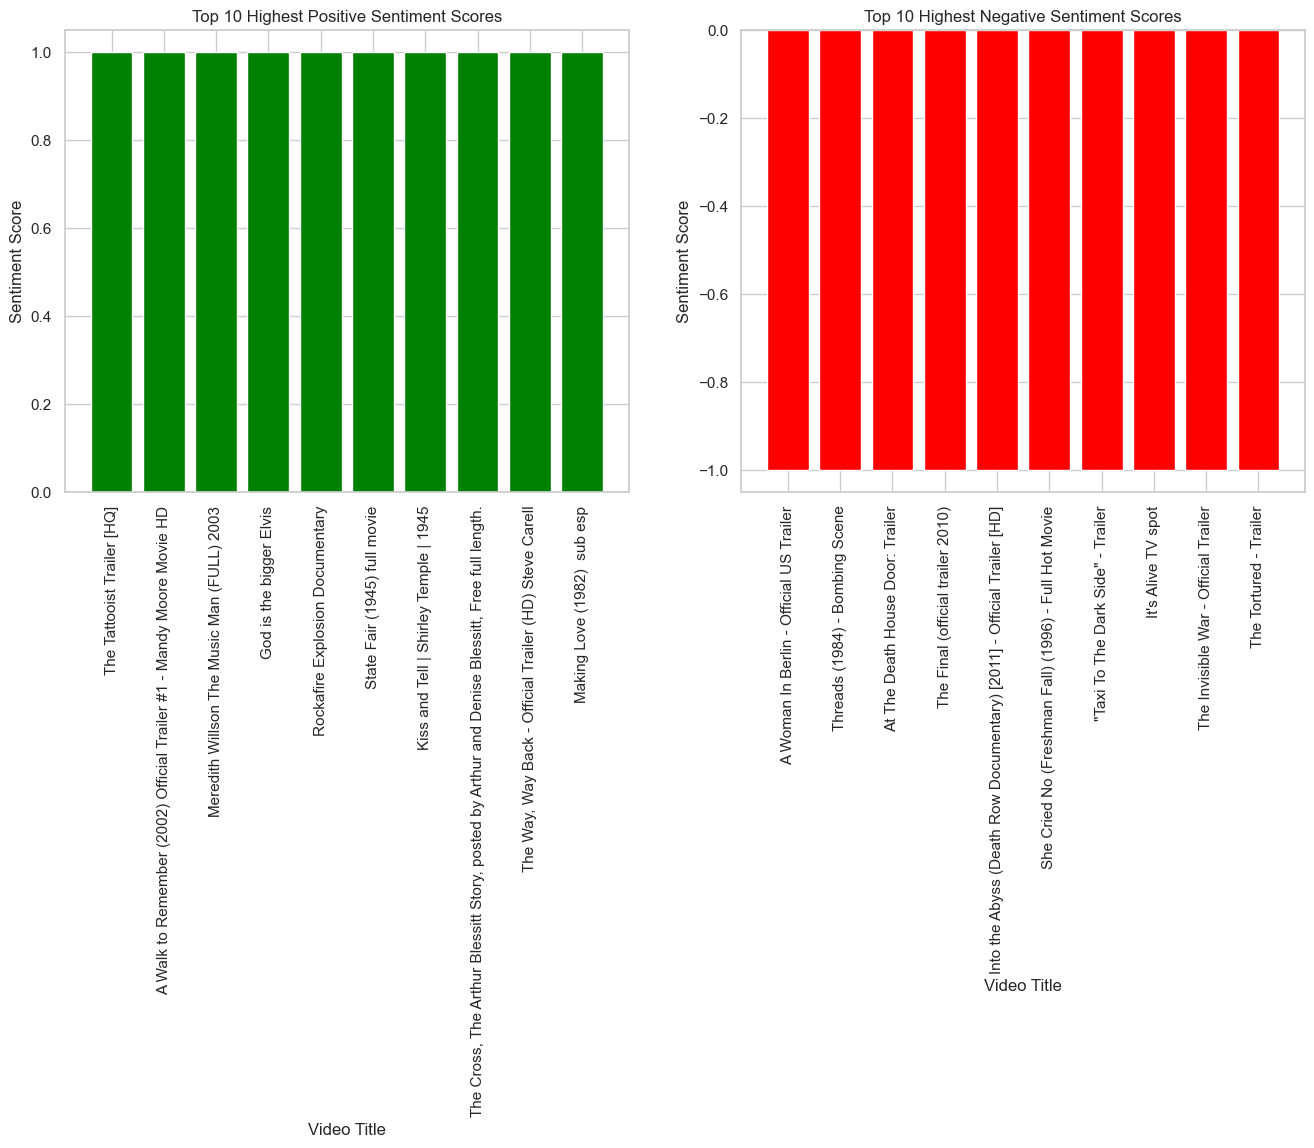

In [91]:
filtered_df = df[df['Scores'] != 0.0000]

top_10_positive_sentiment = filtered_df.sort_values(by='Scores', ascending=False).head(10)


bottom_10_positive_sentiment = filtered_df.sort_values(by='Scores', ascending=True).head(10)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))


ax1.bar(top_10_positive_sentiment['title'], top_10_positive_sentiment['Scores'], color='green')
ax1.set_title('Top 10 Highest Positive Sentiment Scores')
ax1.set_xlabel('Video Title')
ax1.set_ylabel('Sentiment Score')
ax1.tick_params(axis='x', rotation=90)

ax2.bar(bottom_10_positive_sentiment['title'], bottom_10_positive_sentiment['Scores'], color='red')
ax2.set_title('Top 10 Highest Negative Sentiment Scores')
ax2.set_xlabel('Video Title')
ax2.set_ylabel('Sentiment Score')
ax2.tick_params(axis='x', rotation=90)


plt.tight_layout()
plt.show()
